# LSTM for classification


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re


Only keeping the necessary columns.

In [17]:
data = pd.read_csv('https://raw.githubusercontent.com/nluninja/text-mining-dataviz/refs/heads/main/9.%20LSTM/Sentiment_.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [18]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')



4472
16986


<ipython-input-18-0eee58508a82>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] = row[0].replace('rt',' ')
<ipython-input-18-0eee58508a82>:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] = row[0].replace('rt',' ')


In [19]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'].values)
sequences = tokenizer.texts_to_sequences(data['text'].values)


In [20]:
print(data['text'][5])


rt gregabbott_tx tedcruz on my first day i will rescind every illegal executive action taken by barack obama gopdebate foxnews


In [21]:
print(sequences[5])

[6377, 13, 1, 6378, 3, 2124, 166, 97, 541, 35, 1, 104, 582, 2125, 53, 60, 1749, 8, 4264, 18, 608, 2]


In [22]:
for i in sequences[5]:
    print(f'{i} : {tokenizer.index_word[i]}')

6377 : deer
13 : in
1 : the
6378 : headlights
3 : rt
2124 : lizzwinstead
166 : ben
97 : carson
541 : may
35 : be
1 : the
104 : only
582 : brain
2125 : surgeon
53 : who
60 : has
1749 : performed
8 : a
4264 : lobotomy
18 : on
608 : himself
2 : gopdebate


In [23]:
vocabulary_size = len(tokenizer.word_counts)
print(vocabulary_size)

15792


## Sequence Padding

In [24]:
sequence_len = np.array([len(s) for s in sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 30
[('75%', 21.0), ('80%', 21.0), ('85%', 22.0), ('90%', 23.0), ('95%', 24.0), ('100%', 30.0)]


In [25]:
max_sequence_len = 30
X = pad_sequences(sequences, maxlen=max_sequence_len)

print (X[0])

[   0    0    0    0    0    0    0    0    0    3  360  121 2383    1
  694    2   40   59  235   38  208    7 4261  173 1747   13 1310 1394
  735 6374]


In [26]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 30) (7188, 2)
(3541, 30) (3541, 2)


In [27]:
print(X_train[0])
print(Y_train[0])

[   0    0    0    0    0    0    0    0    3 6851   72   12   81  311
    8  966  771  749  102   29  100  308   22  371  197  409    7    8
  184 2870]
[ True False]


In [29]:
tokenizer.index_word[0] = '_PAD_'

## Build, train and evaluate an LSTM model

In [30]:
def load_glove_embedding_matrix(word_index, embed_dim):
    """Load Glove embeddings.

    """
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove*.zip

    path = 'glove.6B.100d.txt'

    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [32]:
USE_GLOVE=True
glove_matrix=None
if USE_GLOVE:
    embedding_dim = 100
    glove_matrix = load_glove_embedding_matrix(tokenizer.word_index, embedding_dim)

--2024-10-29 08:09:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-29 08:09:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-29 08:09:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [33]:
embed_dim = 100
lstm_out = 50

model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_dim, weights=[glove_matrix],
                            mask_zero=True, trainable=True, input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,579,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,579,300 (6.02 MB)

 Trainable params: 1,579,300 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

None


Here we train the Network. We should run much more than 7 epoch, but you can configure an Early Stopping to have the network to stop when loss is not improving.

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [36]:
best_model_file = 'lstm-conll-best-model.weights.h5'

checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True
)

early_stopping_callback = EarlyStopping(monitor="loss", min_delta=0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)

In [37]:

model.fit(X_train, Y_train, epochs = 20, batch_size=32, verbose = 2)

Epoch 1/20
225/225 - 22s - 99ms/step - accuracy: 0.7981 - loss: 0.4668
Epoch 2/20
225/225 - 8s - 34ms/step - accuracy: 0.8497 - loss: 0.3472
Epoch 3/20
225/225 - 15s - 66ms/step - accuracy: 0.8895 - loss: 0.2684
Epoch 4/20
225/225 - 8s - 36ms/step - accuracy: 0.9196 - loss: 0.2057
Epoch 5/20
225/225 - 10s - 43ms/step - accuracy: 0.9371 - loss: 0.1607
Epoch 6/20
225/225 - 11s - 48ms/step - accuracy: 0.9549 - loss: 0.1206
Epoch 7/20
225/225 - 21s - 93ms/step - accuracy: 0.9627 - loss: 0.0993
Epoch 8/20
225/225 - 8s - 34ms/step - accuracy: 0.9638 - loss: 0.0908
Epoch 9/20
225/225 - 12s - 53ms/step - accuracy: 0.9677 - loss: 0.0810
Epoch 10/20
225/225 - 17s - 76ms/step - accuracy: 0.9691 - loss: 0.0748
Epoch 11/20
225/225 - 12s - 53ms/step - accuracy: 0.9711 - loss: 0.0723
Epoch 12/20
225/225 - 21s - 95ms/step - accuracy: 0.9740 - loss: 0.0654
Epoch 13/20
225/225 - 8s - 34ms/step - accuracy: 0.9723 - loss: 0.0642
Epoch 14/20
225/225 - 12s - 51ms/step - accuracy: 0.9743 - loss: 0.0624
Epoch

In [38]:

#since tf 2.6 and later
predictions = model.predict(X_test)
predictions

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


array([[8.09549019e-02, 9.19045091e-01],
       [9.99611080e-01, 3.88927583e-04],
       [1.19513512e-01, 8.80486548e-01],
       ...,
       [8.93551588e-01, 1.06448375e-01],
       [9.99984145e-01, 1.59057072e-05],
       [9.99862552e-01, 1.37374795e-04]], dtype=float32)

In [39]:
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([1, 0, 1, ..., 0, 0, 0])

In [41]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)

print("acc: %.2f" % (acc))

111/111 - 1s - 11ms/step - accuracy: 0.8554 - loss: 0.6232
acc: 0.86


In [42]:
from sklearn.metrics import confusion_matrix,classification_report

In [43]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

<Axes: >

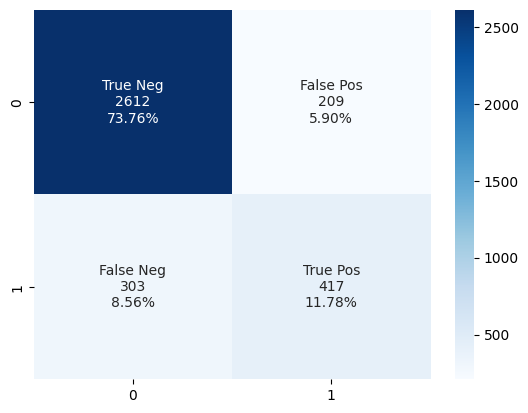

In [44]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [45]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2821
           1       0.67      0.58      0.62       720

    accuracy                           0.86      3541
   macro avg       0.78      0.75      0.77      3541
weighted avg       0.85      0.86      0.85      3541



Let's try it in action

In [46]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  204  625    7  152    6   56 1039   56   47    7  152]]
1/1 - 2s - 2s/step
negative
